# GPS Code Processing

Εξίσωση Παρατήρησης Κώδικα:
$$ P_{j, rec}^{sat} = \rho _{rec}^{sat} + c \cdot (\delta t_{rec} - \delta t^{sat}) + \delta T_{j, rec}^{sat} + \delta I_{j, rec}^{sat} + \epsilon_{j,rec}^{sat} $$
με

* $j$ = 1,2,5, συχνότητα κύματος,
* $\rho _{rec}^{sat} = \rho(t) _{rec}^{sat} = \sqrt((x^{sat}-x_{rec})^2+(z^{sat}-z_{rec})^2+(z^{sat}-z_{rec})^2)$,
* $\delta t_{rec}$ το σφάλμα χρονομέτρου του δέκτη,
* $\delta t^{sat}$ το σφάλμα χρονομέτρου του δορυφόρου,
* $\delta T_{j, rec}^{sat}$ σφάλμα (καθυστέρηση) λόγω τροπόσφαιρας,
* $\delta I_{j, rec}^{sat}$ σφάλμα (καθυστέρηση) λόγω ιονόσφαιράς,
* $\epsilon$ εναπομείναντα σφάλματα

Θα χρειαστούμε:
* ένα (data) RINEX v3.x αρχείο, με τις παρατηρήσεις ενός σταθμού

In [1]:
# set the name of the (GNSS) RINEX file to use
rinex_fn = "../../data/DYNG00GRC_R_20240010000_01D_30S_MO.rnx"

* ένα sp3[cd] αρχείο, με τροχιές δουρφόρων GPS που να καλύπτει το διάστημα των παρατηρήσεων του αρχείου RINEX

In [2]:
# set the name of the Sp3 file for the same satellite, covering the same day
sp3_fn = "../../data/COD0MGXFIN_20240010000_01D_05M_ORB.SP3"

* τις παρακάτω βιβλιοθήκες της Python

In [3]:
from dsoclasses.orbits import sp3c, interpolator
from dsoclasses.geodesy import transformations
from dsoclasses.gnss import systems as gs
from dsoclasses.rinex.gnss.rinex import GnssRinex, fetchv
from dsoclasses.troposphere import gmf, gpt3
from dsoclasses.time.pyattotime import at2pt, fsec2asec
import attotime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

## Παρεμβολή Τροχιών και Διορθώσεων Χρονομέτρων των Δορυφόρων

Για να επεξεργαστούμε τις παρατηρήσεις GPS, θα χρειστούμε τις συν/νες των δορυφόρων, καθώς και τις διορθώσεις των ρολογιών τους στις εποχές των μετρήσεων. Θα χρησιμοποιήσουμε τις καταγραφές του αρχείου sp3 (συνήθως ανά μερικά λεπτά, π.χ. 15min), και έναν αλγόριθμο παρεμβολής για να τις υπολογίσουμε.
```
intrp = interpolator.Sp3Interpolator(sp3_fn, ['G'], 3600, 10, 'CubicSpline', True, ['M', 'E'])
```
Η παραπάνω γραμμή, θα δημιουργήσει ένα αντικείμενο τύπου `Sp3Interpolator` με βάση το αρχείο sp3 `sp3_fn`. Για να πάρουμε τις συν/νες και τη διόρθωση του ρολογιού σε τυχαία εποχή $t$, μπορούμε να γράψουμε:
```
x,y,z,clk = intrp.sat_at(sat, t)
```
όπου `sat` είναι το αναγνωριστικό του δορυφόρου (π.χ. 'G21').

In [4]:
intrp = interpolator.Sp3Interpolator(sp3_fn, ['G'], 3600, 10, 'CubicSpline', True, ['M', 'E'])

Skipping sp3 record for satellite G01: missing clock value ([nan])
Skipping sp3 record for satellite G02: missing clock value ([nan])
Skipping sp3 record for satellite G03: missing clock value ([nan])
Skipping sp3 record for satellite G04: missing clock value ([nan])
Skipping sp3 record for satellite G05: missing clock value ([nan])
Skipping sp3 record for satellite G06: missing clock value ([nan])
Skipping sp3 record for satellite G07: missing clock value ([nan])
Skipping sp3 record for satellite G08: missing clock value ([nan])
Skipping sp3 record for satellite G09: missing clock value ([nan])
Skipping sp3 record for satellite G10: missing clock value ([nan])
Skipping sp3 record for satellite G11: missing clock value ([nan])
Skipping sp3 record for satellite G12: missing clock value ([nan])
Skipping sp3 record for satellite G13: missing clock value ([nan])
Skipping sp3 record for satellite G14: missing clock value ([nan])
Skipping sp3 record for satellite G15: missing clock value ([n

# Γραφική Παράσταση παρατήρησης κώδικα P1 για τον δορυφόρο G21

Παρακάτω, θα απεικονίσουμε τις καταγεγραμμένες παρατηρήσεις του κώδικα P1 όπως καταγράφονται στο αρχείο RINEX. 

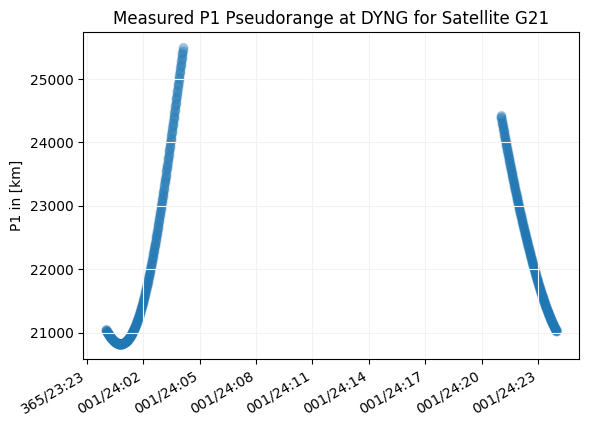

In [5]:
# Δημιουργούμε ένα αντικείμενο τύπου GnssRinex
rnx = GnssRinex(rinex_fn)

# κενές λίστες για τον χρόνο και την P1
epochs = []; p1s = [];

# Για κάθε data block του αρχείου RINEX (επανάλληψη)
for block in rnx:
    # εποχή/χρόνος παρατήρησης (σύμφωνα με το χρονόμετρο του δέκτη)
    t = block.t()
    # για κάθε δουρφόρου του συστήματος GPS που εμπεριέχεται στο data block (επανάλληψη)
    for sat, obs in block.filter_satellite_system("gps", False):
        # θέλουμε τον δορυφόρο 'G21'
        if sat == 'G21':
            # θέλουμε την παρατήρηση του κώδικα στην L1 συχνότητα σε km (αν υπάρχει)
            #try:
            # ως P1 θα πάρουμε οποιαδήποτε παρατήρηση από τις 'C1W', 'C1C', 'C1X', 
            # με αύξουσα σειρά προτεραιότητας
            p1 = fetchv(obs, 'C1W', 'C1C', 'C1X')
            # αποθηκεύουμε το χρόνο παρτήρησης (όπως καταγράφεται από τον δέκτη),
            # και την παρατήρηση P1
            epochs.append(at2pt(t)); p1s.append(p1*1e-3);
            #except:
            #    pass

# Γραφική αναπαράσταση (χρόνος - P1)
fig, ax = plt.subplots()
ax.scatter(epochs, p1s, alpha=0.2)
ax.grid(color='0.95')
plt.ylabel("P1 in [km]")
plt.title("Measured P1 Pseudorange at {:} for Satellite {:}".format(rnx.marker_name, 'G21'))
hours = mdates.HourLocator(interval = 3)
h_fmt = mdates.DateFormatter('%j/%y:%H')
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(h_fmt)
fig.autofmt_xdate()
plt.show()

## Γεωμετρική Απόσταση Δορυφόρου-Δέκτη

$$\rho _{rec}^{sat} = \rho(t) _{rec}^{sat} = \sqrt((x^{sat}-x_{rec})^2+(z^{sat}-z_{rec})^2+(z^{sat}-z_{rec})^2)$$

H "ψευδοαπόσταση" είναι η γεωμετρική απόσταση μεταξύ δορυφόρου την χρονική στιγμή εκπομπής του σήματος και του δέκτη, την χρονική στιγμή της λήψης του.
Οι συν/νες του δορυφόρου, πρέπει να υπολογιστούν για την χρονική στιγμή **εκπομπής** του σήματος και όχι την ώρα **λήψης** (που αναγράφεται στο RINEX). Ο χρόνος που κάνει το σήμα να φτάσει από τον δορυφόρο στον δέκτη, είναι περίπου $\approx .07 [sec]$.

In [6]:
# Γεωμετρική απόσταση δορυφόρου-δέκτη
def geometric_range(rsat, rrec): return np.linalg.norm(rsat-rrec)

# Συν/νες δορυφόρου την εποχή εκπομπής
def sat_at_emission_time(rsta, t_reception, interpolator, sat, verbose=0):
    # αρχικά, η εποχή εκπομπής είναι (προσεγγιστικά) η εποχή λήψης
    t_emission = t_reception
    x, y, z, clk = interpolator.sat_at(sat, t_emission)
    while True:
        # απόσταση δορυφόρου-δέκτη με προσεγγιστικές συν/νες
        r = geometric_range(np.array((x,y,z)), rsta)
        # χρόνος που έκανε το σήμα να δθανύσει την απόσταση δορυφόρου-δέκτη
        dt = r / gs.C
        # χρόνος εκπομπής
        t_emission = t_reception - fsec2asec(dt)
        # συν/νες δορυφόρου στον χρόνο εκπομπής
        xnew, ynew, znew, clk = interpolator.sat_at(sat, t_emission)
        # όριο σύγκλισης: .1m
        if abs(xnew-x)<.1 and abs(ynew-y)<.1 and abs(znew-z)<.1:
            if verbose>0:
                print("[DEBUG] t_emission is {:} and t_reception is {:}".format(t_emission.strftime("%H:%M:%S.%f"), t_reception.strftime("%H:%M:%S.%f")))
            return xnew, ynew, znew, clk, dt
        else:
            x=xnew; y=ynew; z=znew;

### Ψευδοαπόσταση (μέτρηση) - Γεωμετρική Απόσταση

Παρακάτω θα απεικονίσουμε την διαφορά της μετρημένης απόστασης δορυφόρου-δέκτη με την αντίστοιχη γεωμετρική απόσταση (υπόλοιπα). Η παρατήρηση περιέχει μια σειρά σφαλμάτων. Θα χρειστούμε (προσεγγιστικές) συν/νες του δέκτη, τις οποίες μπορούμε να πάρουμε από το αρχείο RINEX.

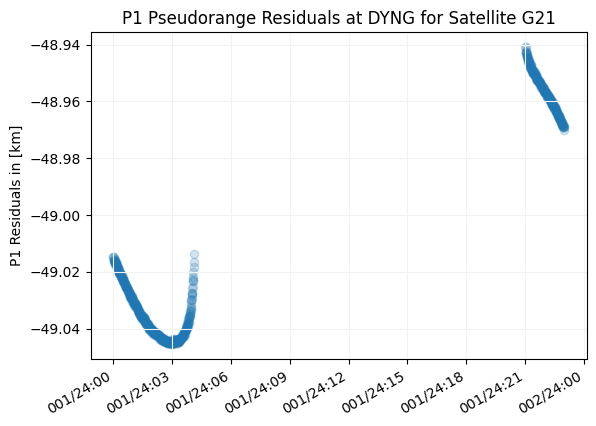

In [7]:
# προσεγγιστικές συν/νες δέκτη (από RINEX)
rsta = np.array(rnx.approx_cartesian())

# κενές λίστες για τον χρόνο και την P1
epochs = []; p1s = []; dts = [];

for block in rnx:
    t = block.t()
    for sat, obs in block.filter_satellite_system("gps", False):
        if sat == 'G21':
            try:
                p1 = fetchv(obs, 'C1W', 'C1C', 'C1X')
                #συν/νες δουρφόρου την εποχή εκπομπής
                xsat, ysat, zsat, csat, dt = sat_at_emission_time(rsta, t, intrp, 'G21')
                r = geometric_range(np.array((xsat,ysat,zsat)), rsta)
                p1s.append((p1-r)*1e-3); epochs.append(at2pt(t)); dts.append(dt);
            except:
                pass

# Γραφική αναπαράσταση (χρόνος - υπόλοιπα P1)
fig, ax = plt.subplots()
ax.scatter(epochs, p1s, alpha=0.2)
ax.grid(color='0.95')
plt.ylabel("P1 Residuals in [km]")
plt.title("P1 Pseudorange Residuals at {:} for Satellite {:}".format(rnx.marker_name, 'G21'))
hours = mdates.HourLocator(interval = 3)
h_fmt = mdates.DateFormatter('%j/%y:%H')
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(h_fmt)
fig.autofmt_xdate()
plt.show()

## Διορθώσεις Ρολογιών Δορυφόρων

Το σφάλμα χρονομέτρου του δορυφόρου $\delta t^{sat}(t)$ μπορούμε:
* να το εκτιμήσουμε με συνόρθωση (μαζί με άλλες μαραμέτρους ενδιαφέροντος),
* να το εξάγουμε από τα αρχεία sp3 ή navigation (RINEX)

Για να το μοντελοποιήσουμε, συνήθως χρησιμοποιούμε ένα πολυώνυμο 2ου βαθμού (bias, drift).

Παρακάτω, θα χρησιμοποιήσουμε τις διορθώσεις (για κάθε δορυφόρο) που αναγράφονται σεο αρχείο sp3, και θα κάνουμε παρεμβολή για τις εποχές μετρήσεων.

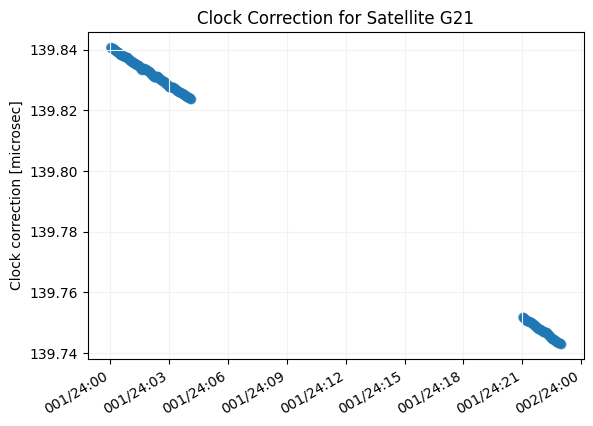

In [8]:
# κενές λίστες για τον χρόνο και τη διόρθωση ρολογιού
epochs = []; cs = [];

for block in rnx:
    t = block.t()
    for sat, obs in block.filter_satellite_system("gps", False):
        if sat == 'G21':
            try:
                p1 = fetchv(obs, 'C1W', 'C1C', 'C1X')
                xsat, ysat, zsat, csat, _ = sat_at_emission_time(rsta, t, intrp, 'G21')
                cs.append(csat*1e6); epochs.append(at2pt(t));
            except:
                pass

# Γραφική αναπαράσταση (χρόνος - σφάλμα ρολογιού δορυφόρου)
fig, ax = plt.subplots()
ax.scatter(epochs, cs, alpha=0.2)
ax.grid(color='0.95')
plt.ylabel("Clock correction [microsec]")
plt.title("Clock Correction for Satellite {:}".format('G21'))
hours = mdates.HourLocator(interval = 3)
h_fmt = mdates.DateFormatter('%j/%y:%H')
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(h_fmt)
fig.autofmt_xdate()
plt.show()

Εισάγωντας τη διόρθωση αυτή, τα υπόλοιπα θα πρέπει να μειωθούν (κατά απόλυτη τιμή). Θα τα υπολογίσουμε μέσω της:
$$P_{j, rec}^{sat} + c \cdot \delta t^{sat} \approx \rho _{rec}^{sat}  + \epsilon_{j,rec}^{sat}$$
όπου το αριστερό μέλος είναι γνωστές ποσότητες (observed) και το αριστερό οι υπολογισμένες (computed).

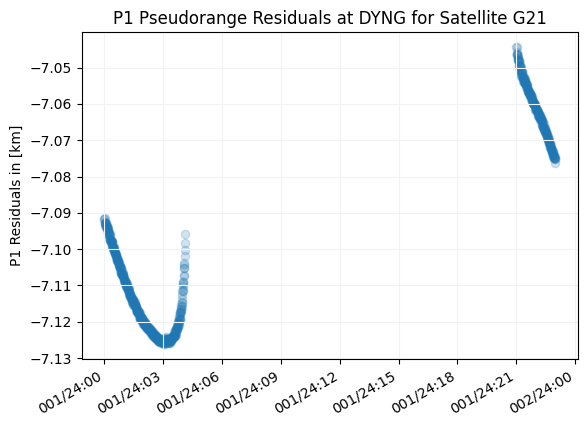

In [9]:
# κενές λίστες για τον χρόνο και την P1
epochs = []; p1s = [];

for block in rnx:
    t = block.t()
    for sat, obs in block.filter_satellite_system("gps", False):
        if sat == 'G21':
            try:
                p1 = fetchv(obs, 'C1W', 'C1C', 'C1X')
                xsat, ysat, zsat, csat, _ = sat_at_emission_time(rsta, t, intrp, 'G21')
                r = geometric_range(np.array((xsat,ysat,zsat)), rsta)
                # διόρθωση ρολογιού δορυφόου σε [m]
                dtsat = gs.C * csat
                p1s.append((p1+dtsat-r)*1e-3); epochs.append(at2pt(t));
            except:
                pass

# Γραφική αναπαράσταση (χρόνος - υπόλοιπα P1)
fig, ax = plt.subplots()
ax.scatter(epochs, p1s, alpha=0.2)
ax.grid(color='0.95')
plt.ylabel("P1 Residuals in [km]")
plt.title("P1 Pseudorange Residuals at {:} for Satellite {:}".format(rnx.marker_name, 'G21'))
hours = mdates.HourLocator(interval = 3)
h_fmt = mdates.DateFormatter('%j/%y:%H')
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(h_fmt)
fig.autofmt_xdate()
plt.show()

## Καθυστέρηση Λόγω Ιονόσφαιρας και Γραμμικοί Συνδυασμοί

Το σφάλμα της ιονόσφαιρας εξαρτάται από το τετράγωνο της συχνότητας (του κύμματος, $a_i = 40.3 / f^2$). Μπορούμε λοιπόν, να απαλείψουμε (σχεδόν) το σφάλμα της ιονόσφαιρας, χρησιμοποιώντας έναν κατάλληλο γραμμικό συνδυασμό των δύο συχνοτήτων του συστήματος:

$$PC = \frac{f_1^2 P_1 - f_2^2 P_2}{f_1^2 - f_2^2}$$

αντίστοιχος συναδυασμός μπορεί να φτιαχτεί και για τις παρατηρήσεις φάσης.

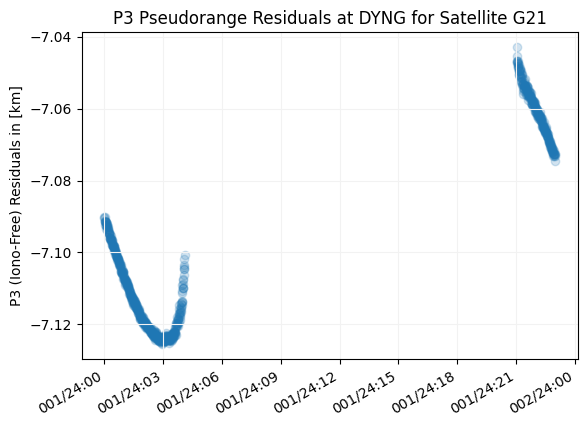

In [10]:
# κενές λίστες για τον χρόνο και την P3
epochs = []; p3s = [];

f1 = gs.GPS_L1_FREQ # MHz
f2 = gs.GPS_L2_FREQ # MHz
fac = f1*f1 - f2*f2

for block in rnx:
    t = block.t()
    for sat, obs in block.filter_satellite_system("gps", False):
        if sat == 'G21':
            try:
                p1 = fetchv(obs, 'C1W', 'C1C', 'C1X')
                p2 = fetchv(obs, 'C2W', 'C2C', 'C2D', 'C2P', 'C2X', 'C2S', 'C2L')
                xsat, ysat, zsat, csat, _ = sat_at_emission_time(rsta, t, intrp, 'G21')
                r = geometric_range(np.array((xsat,ysat,zsat)), rsta)
                dtsat = gs.C * csat
                # γραμμικός συνδυασμός ελεύθερος ιονόσφαιρας
                pc = f1*f1*p1/fac - f2*f2*p2/fac
                p3s.append((pc+dtsat-r)*1e-3); epochs.append(at2pt(t));
            except:
                pass

# Γραφική αναπαράσταση (χρόνος - υπόλοιπα P3)
fig, ax = plt.subplots()
ax.scatter(epochs, p3s, alpha=0.2)
ax.grid(color='0.95')
plt.ylabel("P3 (Iono-Free) Residuals in [km]")
plt.title("P3 Pseudorange Residuals at {:} for Satellite {:}".format(rnx.marker_name, 'G21'))
hours = mdates.HourLocator(interval = 3)
h_fmt = mdates.DateFormatter('%j/%y:%H')
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(h_fmt)
fig.autofmt_xdate()
plt.show()

### Επίδραση Ιονόσφαιρας σε Συνάρτηση της Γωνίας Ύψους

Όταν ο δορυφόρος είναι χαμηλά στον (τοπικό) ορίζοντα, το κύμα διανύει μεγαλύτερη απόσταση μέσα στην ατμόσφαιρα και συνεπώς, δέχεται μεγαλύτερη επίδραση (σφάλμα) από αυτή. Για να δούμε την επίδραση της ατμόσφαιρας σε κάθε παρατήρηση, θα πρέπει να υπολογίσουμε την γωνία ύψους (λήψης) δορυφόρου-δέκτη. Αυτή είναι εύκολα υπολογίσιμη σε τοποκεντρικές συν/νες, με κέντρο τον δέκτη.

In [11]:
# Μετατροπή σε ελλειψοειδείς συν/νες (δέκτης)
lat, lon, hgt = transformations.car2ell(rsta[0], rsta[1], rsta[2])
# Πίνακας στροφής (x, y, z) -> (e, n, u)
Rt = transformations.geodetic2lvlh(lat, lon)
R = Rt.transpose()

In [12]:
def azele(R, rsat, rsta):
    # cartesian difference vector
    dr = rsat - rsta
    # topocentric vector
    enu = R @ (rsat - rsta)
    # compute azimouth and elevation
    r  = np.linalg.norm(enu)
    az = np.arctan2(enu[0], enu[1])
    el = np.arcsin(enu[2] / r)
    return r, az, el

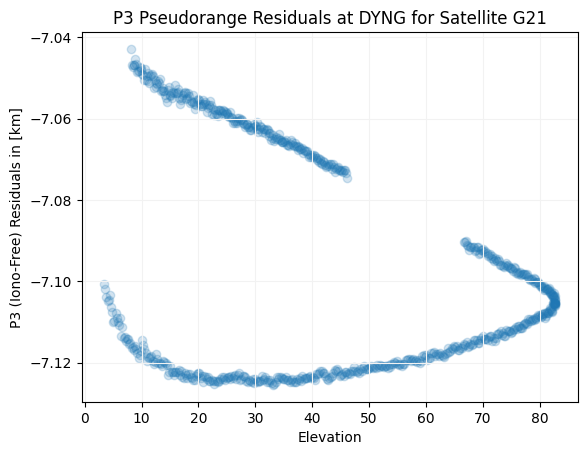

In [13]:
# κενές λίστες για τον χρόνο και την P3
els = []; p3s = [];

for block in rnx:
    t = block.t()
    for sat, obs in block.filter_satellite_system("gps", False):
        if sat == 'G21':
            try:
                p1 = fetchv(obs, 'C1W', 'C1C', 'C1X')
                p2 = fetchv(obs, 'C2W', 'C2C', 'C2D', 'C2P', 'C2X', 'C2S', 'C2L')
                xsat, ysat, zsat, csat, _ = sat_at_emission_time(rsta, t, intrp, 'G21')
                r = geometric_range(np.array((xsat,ysat,zsat)), rsta)
                dtsat = gs.C * csat
                pc = f1*f1*p1/fac - f2*f2*p2/fac
                # υπολογισμός γωνίας ύψους
                _, _, el = azele(R, np.array((xsat, ysat, zsat)), rsta)
                p3s.append((pc+dtsat-r)*1e-3); els.append(np.degrees(el));
            except:
                pass

# Γραφική αναπαράσταση (γωνία ύψους - υπόλοιπα P3)
fig, ax = plt.subplots()
ax.scatter(els, p3s, alpha=0.2)
ax.grid(color='0.95')
plt.ylabel("P3 (Iono-Free) Residuals in [km]")
plt.title("P3 Pseudorange Residuals at {:} for Satellite {:}".format(rnx.marker_name, 'G21'))
plt.xlabel("Elevation")
plt.show()

## Καθυστέρηση Λόγω Τροπόσφαιρας

Η επίδραση της τροπόσφαιρας μπορεί να χωριστεί σε δύο μέρη:
 - τη συνιστώσα που προκαλείται από το υδροστατικό κομμάτι της τροπόσφαιρας $N_{dry}$, και
 - αυτή που προκαλείται από το υγρό κομμάτι $N_{wet}$

Η πρώτη ($N_{dry}$) συνιστά περίπου το 90% της συνολικής καθυστέρησης!

$$T = ZHD \cdot m_{dry}(elevation) + ZWD \cdot m_{wet}(elevation)$$

με

* $T$ καθυστέρηση σε [m],
* $zhd$ καθυστέρηση λόγω του υδροστατικού κομματιού στο ζενίθ,
* $zhd$ καθυστέρηση λόγω του υγρού κομματιού στο ζενίθ,
* $m_{dry}(elevation)$ και $m_{wet}(elevation)$ συναρτήσεις απεικόνισης της καθυστέρησης σε τυχαία γωνία ύψους

$$zhd = \frac{0.0022767 \cdot p}{1-0.00266 \cdot \cos{2\phi} - 0.00028 \cdot h} [m]$$, (Saastamoinen), όπου:

* $p$ πίεση στην επιφάνεια της γης, στον σταθμό καταγραφής σε [hPa],
* $\phi$ γεωδαιτικό πλάτος και
* $h$ ελλειψοειδές υψόμετρο

Το κομμάτι της επίδρασης που προκαλείται από το υγρό κομμάτι της τροπόσφαιρας, είναι δύσκολο να μοντελοποιηθεί και συνήθως εκτιμάται. 

Οι συναρτήσεις απεικόνισης (mapping functions) έχουν συνήθως τη μορφή:
$$ m_{i} = \frac{1}{\sin{el} + \frac{\alpha _i}{\sin{el} + \frac{\beta _i}{\sin{el}+\frac{c_i}{\dots}}}} $$

με $i$ dry, wet και $\alpha _i$, $\beta_i$, $c_i$, παράμετροι του μοντέλου.

In [14]:
# Υπολογισμός ZHD και προσεγγιστικού ZWD με χρήση μετεωρολογικών δεδομένων GPT3
def static_tropo_delay(t, lat, lon, hgt):
    meteo = gpt3.gpt3(t, lon, lat, hgt, "../../data/gpt3_5.grd")
    zhd = gpt3.saastamoinen_zhd(lat, hgt, meteo['p'])
    zwd = gpt3.askne_zwd(meteo['e'], meteo['Tm'], meteo['la'])
    return zhd, zwd

zhd, zwd = static_tropo_delay(rnx.time_first_obs, lat, lon, hgt)
print("GPT3 Model: ZHD={:.3f} ZWD={:.3f}".format(zhd, zwd))

GPT3 Model: ZHD=2.191 ZWD=0.074


In [15]:
# Υπολογισμός καθυστέρησης λόγω τροπόσφαιρας με χρήση του Global Mapping Function (gmf)
def tropo_delay(t, lat, lon, hgt, el, zhd, zwd):
    gmfh, gmfw = gmf.gmf(t, lat, lon, hgt, np.pi/2-el)
    return zhd * gmfh + zwd * gmfw

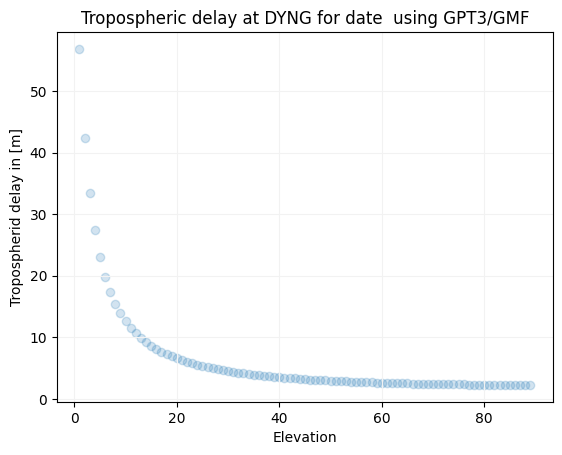

In [16]:
trp = []; els = [];
for el in range(1, 90):
    trp.append(tropo_delay(rnx.time_first_obs, lat, lon, hgt, np.radians(el), zhd, zwd))
    els.append(el)

# Γραφική αναπαράσταση
fig, ax = plt.subplots()
ax.scatter(els, trp, alpha=0.2)
ax.grid(color='0.95')
plt.ylabel("Tropospherid delay in [m]")
plt.title("Tropospheric delay at {:} for date {:} using GPT3/GMF".format(rnx.marker_name, rnx.time_first_obs))
plt.xlabel("Elevation")
plt.show()

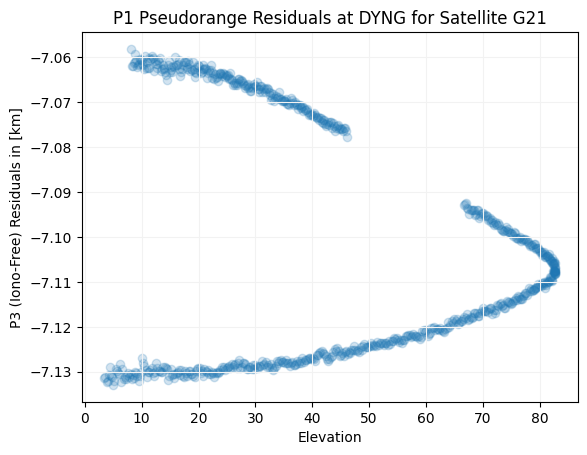

In [17]:
# κενές λίστες για τον χρόνο και την P3
els = []; p3s = [];

for block in rnx:
    t = block.t()
    for sat, obs in block.filter_satellite_system("gps", False):
        if sat == 'G21':
            try:
                p1 = fetchv(obs, 'C1W', 'C1C', 'C1X')
                p2 = fetchv(obs, 'C2W', 'C2C', 'C2D', 'C2P', 'C2X', 'C2S', 'C2L')
                xsat, ysat, zsat, csat, _ = sat_at_emission_time(rsta, t, intrp, 'G21')
                r = geometric_range(np.array((xsat,ysat,zsat)), rsta)
                dtsat = gs.C * csat
                pc = f1*f1*p1/fac - f2*f2*p2/fac
                _, _, el = azele(R, np.array((xsat, ysat, zsat)), rsta)
                # σφάλμα τροπόσφαιρας
                dT = tropo_delay(rnx.time_first_obs, lat, lon, hgt, el, zhd, zwd)
                p3s.append((pc+dtsat-r-dT)*1e-3); els.append(np.degrees(el));
            except:
                pass

# Γραφική αναπαράσταση (γωνία ύψους - υπόλοιπα P3)
fig, ax = plt.subplots()
ax.scatter(els, p3s, alpha=0.2)
ax.grid(color='0.95')
plt.ylabel("P3 (Iono-Free) Residuals in [km]")
plt.title("P1 Pseudorange Residuals at {:} for Satellite {:}".format(rnx.marker_name, 'G21'))
plt.xlabel("Elevation")
plt.show()